# Trying to explain 'lensing is too low' through baryonic effects 

using baryonification model to match lensing in measurements

[Saito et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.460.1457S/abstract) (for wp)

Lange et al. 2019 and Wibking et al. 2019 discuss 'lensing is low'

1) Use halo tools to generate an HOD and plot a CMASS like wp and DS

2) Apply the displacement model and redo wp and DS with the same HOD. How are the two plots different?

In [126]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from astropy.io import ascii

from halotools.sim_manager import UserSuppliedHaloCatalog, UserSuppliedPtclCatalog

from astropy.cosmology import Planck15

## CMASS data 

In [94]:
data_dir = '/Users/fardila/Documents/GitHub/baryonic_effects/CMASS/data/'
wp_data_file = 'wpNSdebiasedboss5003.txt'
ds_data_file = 'cmass_deltasigma_0.43_0.7.txt'

In [95]:
wp_data = ascii.read(data_dir+wp_data_file, names = ['rp','wp','wp_err'])
ds_data = ascii.read(data_dir+ds_data_file, names = ['rp','ds','ds_err'])

## simulation: MDPL2 

### load catalogs 

In [96]:
data_directory = '/Users/fardila/Documents/Data/baryonic_effects/CMASS/'
halo_cat_file = 'halo_catalogs/mdpl2_hlist_0.65650_Mvir11.2.csv'
### "row_id","Mvir","Rvir","M200c","M500c","x","y","z","scale"
particle_cat_file = 'particle_catalogs/mdpl2_particles_0.6565_10m.dat'
### "x","y","z"

In [16]:
# import csv
# full_halo_catalog = csv.reader( open(data_directory+halo_cat_file))
# # %time row_id = [row[0] for row in full_halo_catalog]

CPU times: user 2min 50s, sys: 4.34 s, total: 2min 55s
Wall time: 2min 55s


much faster with pandas

In [19]:
# %time halo_df = pd.read_csv(data_directory+halo_cat_file)

CPU times: user 1min 48s, sys: 26.3 s, total: 2min 14s
Wall time: 2min 16s


In [97]:
halo_df = pd.read_csv(data_directory+halo_cat_file)
particles_df = pd.read_csv(data_directory+particle_cat_file, delimiter ='     ', names=['x','y','z'])

/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [98]:
ptcl_x = particles_df['x'].values
ptcl_y = particles_df['y'].values
ptcl_z = particles_df['z'].values

In [122]:
redshift = (1./0.65650)-1. #z=0.523
Lbox = 1000.
particle_mass = 1.51e9
num_ptcl_per_dim = 3840
x = halo_df['x'].values
y = halo_df['y'].values
z = halo_df['z'].values
vx = halo_df['vx'].values
vy = halo_df['vy'].values
vz = halo_df['vz'].values
mass = halo_df['Mvir'].values
radius = halo_df['Rvir'].values
ids = halo_df['row_id'].values #np.arange(0, len(halo_catalog))
simname = 'MDPL2'
upid = halo_df['upId'].values

In [104]:
#get concentrations
from halotools.empirical_models import NFWProfile

nfw = NFWProfile(redshift=redshift, mdef = 'vir',conc_mass_model = 'dutton_maccio14')

model_conc = nfw.conc_NFWmodel(prim_haloprop = mass)

In [123]:
ptclcat = UserSuppliedPtclCatalog(x = ptcl_x, y = ptcl_y, z = ptcl_z, Lbox = Lbox, particle_mass = particle_mass,
                                  redshift = redshift)
halo_catalog = UserSuppliedHaloCatalog(user_supplied_ptclcat = ptclcat, redshift = redshift, simname = simname,
                                       Lbox = Lbox, particle_mass = particle_mass, num_ptcl_per_dim =num_ptcl_per_dim,
                                       halo_x = x, halo_y = y, halo_z = z,
                                       halo_vx = vx, halo_vy = vy, halo_vz = vz, 
                                       halo_id = ids, halo_mvir = mass, halo_rvir = radius,
                                       halo_nfw_conc = model_conc, halo_upid = upid )


In [124]:
#add hostid
add_halo_hostid(halo_catalog.halo_table)

### create HOD 

HOD model to match [Johannes' paper](https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.5771L/abstract)

In [155]:
from halotools.empirical_models import PrebuiltHodModelFactory, HodModelFactory
from halotools.empirical_models import AssembiasZheng07Cens, AssembiasZheng07Sats, TrivialPhaseSpace, NFWPhaseSpace
from halotools.sim_manager import FakeSim
from halotools.mock_observables import return_xyz_formatted_array
from halotools.utils import add_halo_hostid

from scipy.special import erf

In [166]:
#create new HOD model. code from Johannes
class IncompleteAssembiasZheng07Cens(AssembiasZheng07Cens):

    def __init__(self, **kwargs):
        AssembiasZheng07Cens.__init__(self, **kwargs)
        self.param_dict['f_compl'] = 1.0

    def mean_occupation(self, **kwargs):
        # Retrieve the array storing the mass-like variable
        if 'table' in list(kwargs.keys()):
            mass = kwargs['table'][self.prim_haloprop_key]
        elif 'prim_haloprop' in list(kwargs.keys()):
            mass = np.atleast_1d(kwargs['prim_haloprop'])
        else:
            msg = ("\nYou must pass either a ``table`` or ``prim_haloprop`` argument \n"
                "to the ``mean_occupation`` function of the ``Zheng07Cens`` class.\n")
            raise HalotoolsError(msg)

        logM = np.log10(mass)
        
        mean_ncen = self.param_dict['f_compl']*0.5*(1.0 + erf(
            (logM - self.param_dict['logMmin']) / self.param_dict['sigma_logM']))

        return mean_ncen

#just need to change the centrals occupation. the rest is the same as Zheng07
def Lange19_HOD_model(redshift, cosmology, secondary_haloprop_key):

    cens_occ_model = IncompleteAssembiasZheng07Cens(threshold=-21.5, redshift=redshift,
                                                    sec_haloprop_key=secondary_haloprop_key)
    cens_prof_model = TrivialPhaseSpace(redshift=redshift, cosmology=cosmology)
    sats_occ_model = AssembiasZheng07Sats(threshold=-21.5, redshift=redshift,
                                          modulate_with_cenocc=True, cenocc_model=cens_occ_model,
                                          sec_haloprop_key=secondary_haloprop_key)
    sats_occ_model._suppress_repeated_param_warning = True
    sats_prof_model = NFWPhaseSpace(redshift=redshift, cosmology=cosmology)

    model = HodModelFactory(
        centrals_occupation=cens_occ_model, centrals_profile=cens_prof_model,
        satellites_occupation=sats_occ_model,
        satellites_profile=sats_prof_model)

    return model

In [167]:
model_instance = Lange19_HOD_model(redshift = redshift, cosmology=Planck15, secondary_haloprop_key='halo_nfw_conc') #, conc_mass_model = 'dutton_maccio14')

# halo_catalog = FakeSim()
model_instance.populate_mock(halo_catalog)

# model_instance.param_dict['logMmin'] = 12.1
# model_instance.mock.populate()

/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


In [158]:
x = model_instance.mock.galaxy_table['x']
y = model_instance.mock.galaxy_table['y']
z = model_instance.mock.galaxy_table['z']
all_positions = return_xyz_formatted_array(x, y, z)

In [159]:
px = model_instance.mock.ptcl_table['x']
py = model_instance.mock.ptcl_table['y']
pz = model_instance.mock.ptcl_table['z']

# Nptcls_to_keep = int(1e4)
# randomizer = np.random.random(len(model_instance.mock.ptcl_table))
# sorted_randoms = np.sort(randomizer)
# ptcl_mask = np.where(sorted_randoms < sorted_randoms[Nptcls_to_keep])[0]
# particle_positions = return_xyz_formatted_array(px, py, pz, mask = ptcl_mask)
particle_positions = return_xyz_formatted_array(px, py, pz)

### measure clustering 

In [160]:
from halotools.mock_observables import wp

In [161]:
pi_max = 40.
rp_bins = np.logspace(-1,1.25,15)
rp_bin_centers = (rp_bins[:1] + rp_bins[1:])/2.


wp_all = wp(all_positions, rp_bins, pi_max, period=model_instance.mock.Lbox, num_threads='max')

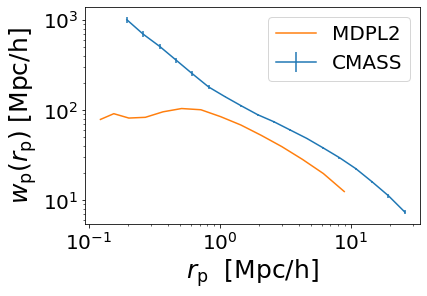

In [162]:
plt.errorbar(wp_data['rp'],wp_data['wp'], yerr = wp_data['wp_err'], label='CMASS')

plt.plot(rp_bin_centers, wp_all, label=r'MDPL2')

plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=25)
plt.ylabel(r'$w_{\rm p}(r_{\rm p})$ $\rm{[Mpc/h]}$', fontsize=25)
# plt.title(r'$M_{\ast} > 10^{10.25}M_{\odot}$', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()


## measure weak lensing 

In [163]:
from halotools.mock_observables import delta_sigma

In [164]:
rp_bins = np.logspace(-1, 1, 15)

particle_masses = halo_catalog.particle_mass
period=model_instance.mock.Lbox
downsampling_factor = (halo_catalog.num_ptcl_per_dim**3)/float(len(particle_positions))

rp_bins = np.logspace(-1,1,15)

rp, result_mstar11_in_mpc = delta_sigma(all_positions, particle_positions,
                    particle_masses, downsampling_factor,
                    rp_bins, period, cosmology=Planck15, num_threads='max')

length_unit_conversion = 1e6
result_mstar11_in_pc = result_mstar11_in_mpc/length_unit_conversion**2

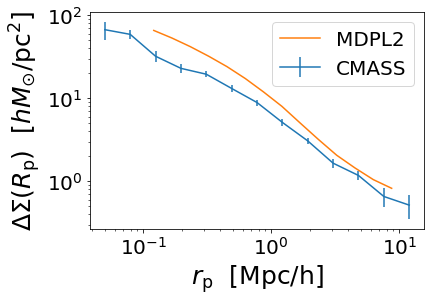

In [165]:
plt.errorbar(ds_data['rp'],ds_data['ds'], yerr = ds_data['ds_err'], label='CMASS')
plt.plot(rp, result_mstar11_in_pc, label='MDPL2')
plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=25)
plt.ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=25)
plt.legend(loc='best', fontsize=20)
plt.show()